# Predicting water solubility - Part II?

> Feature selection

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: ../my_icons/fruit.jpg

Water solubility is one onf the main players in lead optimization. If a molecule is not soluble, we might have problems in biological assays and also to make it reach the desired target in vivo. 

This post is the second of a series that will end with a prediction model to estimate water solubility. In this first notebook, we will explore some feature selection methods in order to train a regression model with robust performance and interpretability. 

# Requirements

 - rdkit >= 2020.09.1
 - pandas >= 1.1.3
 - seaborn
 - matplotlib
 - fastcore (!conda install fastcore)


In this tutorial we'll use a dataset compiled by [Sorkun et al (2019)](https://www.nature.com/articles/s41597-019-0151-1) from multiple projects to predict water solubility. You can download the original dataset from [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8).

> ```At the end of the notebook I added a class to process the original dataset in order to remove salts, mixtures, neutralize charges and generate canonical SMILES. I highly recommend checking each structure before modeling. ```

In this notebook we'll cover three main topics:

   - **Featurization of molecules**
   - **What's the correlation between features?**
   - **Feature selection methods**
   - **Feature transformation**

# Background

Drug solubility is a critical factor in drug development. If a drug is not soluble enough or doesn't dissolve readily its intestinal absoption will be compromised, leading to low concentration in the blood circulation and reduced (or none) biological activity. 

Crystal formation of low soluble drugs may also lead to toxicity. In practical terms, poor solubility is one of the factors that lead to fail in drug discovery projects. Therefore, medicinal chemists work hard to design molecules tha have the intended bioactivity and that can display the desired effect in vivo. 

Despite being conceptually easy to understand solubility, its estimation isn't that friendly. That's because the intrinsic solubility of a molecule depends on many factors, including its size, shape, the ability to make intermolecular interactions, crystal packing

# Import modules

In [4]:
#collapse
#%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, normalize, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.feature_selection import mutual_info_regression, RFECV,SelectFromModel,RFE,VarianceThreshold
from functools import partial
from pathlib import Path
from joblib import load, dump

from scipy import stats
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles, MolToSmiles

from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator


/home/marcossantana/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/marcossantana/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/marcossantana/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/marcossantana/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
np.random.seed(5)

In [6]:
sns.set(rc={'figure.figsize': (16, 16)})
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=1.5)

# Load Data

In [7]:
data = pd.read_csv('../_data/water_solubility_nooutliers.csv')

In [8]:
#collapse_output
data.head()

ID                                        Name  \
0   A-3  N,N,N-trimethyloctadecan-1-aminium bromide   
1   A-4                    Benzo[cd]indol-2(1H)-one   
2   A-5                        4-chlorobenzaldehyde   
3  A-10                                vinyltoluene   
4  A-11        3-(3-ethylcyclopentyl)propanoic acid   

                                               InChI  \
0  InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...   
1  InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...   
2        InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H   
3  InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3   
4  InChI=1S/C10H18O2/c1-2-8-3-4-9(7-8)5-6-10(11)1...   

                      InChIKey                               SMILES  \
0  SZEMGTQCPRNXEG-UHFFFAOYSA-M  [Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C   
1  GPYLCFQEKPUWLD-UHFFFAOYSA-N                 O=C1Nc2cccc3cccc1c23   
2  AVPYQKSLYISFPO-UHFFFAOYSA-N                      Clc1ccc(C=O)cc1   
3  JZHGRUMIRATHIU-UHFFFAOYSA-N                       Cc1cccc(C=C)c1   
4  WVRFSLWCFASCIS-UHFFFAOYSA-N                  CCC1CCC(CCC(O)=O)C1   

   Solubility   SD  Ocurrences Group    MolWt  ...  NumAromaticRings  \
0   -3.616127  0.0           1    G1  392.510  ...               0.0   
1   -3.254767  0.0           1    G1  169.183  ...               2.0   
2   -2.177078  0.0           1    G1  140.569  ...               1.0   
3   -3.123150  0.0           1    G1  118.179  ...               1.0   
4   -3.286116  0.0           1    G1  170.252  ...               0.0   

   NumSaturatedRings  NumAliphaticRings  RingCount   TPSA   LabuteASA  \
0                0.0                0.0        0.0   0.00  158.520601   
1                0.0                1.0        3.0  29.10   75.183563   
2                0.0                0.0        1.0  17.07   58.261134   
3                0.0                0.0        1.0   0.00   55.836626   
4                1.0                1.0        1.0  37.30   73.973655   

   BalabanJ     BertzCT               processed_smiles             class  
0  0.000000  210.377334  CCCCCCCCCCCCCCCCCC[N+](C)(C)C  slightly soluble  
1  2.582996  511.229248           O=C1Nc2cccc3cccc1c23  slightly soluble  
2  3.009782  202.661065                O=Cc1ccc(Cl)cc1  slightly soluble  
3  3.070761  211.033225                 C=Cc1cccc(C)c1  slightly soluble  
4  2.145839  153.917569            CCC1CCC(CCC(=O)O)C1  slightly soluble  

[5 rows x 28 columns]

# Featurization

In this dataset 17 features were already calculated for each molecule. These features include a range of physichochemical properties (e.g. MolWt, MolLogP and MolMR), atomic counts (e.g. HeavyAtomCount, NumHDonors and Acceptors) more abstract topological descriptors (e.g. BalabanJ, BertzCT).

In [9]:
descriptors = ['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT']

var =  ['Solubility']+ descriptors 

In [10]:
print(len(descriptors))

17


We can check the correlation between each feature and solubility using seaborn's regplot:

In [11]:
nr_rows = 6
nr_cols = 3
target = 'Solubility'

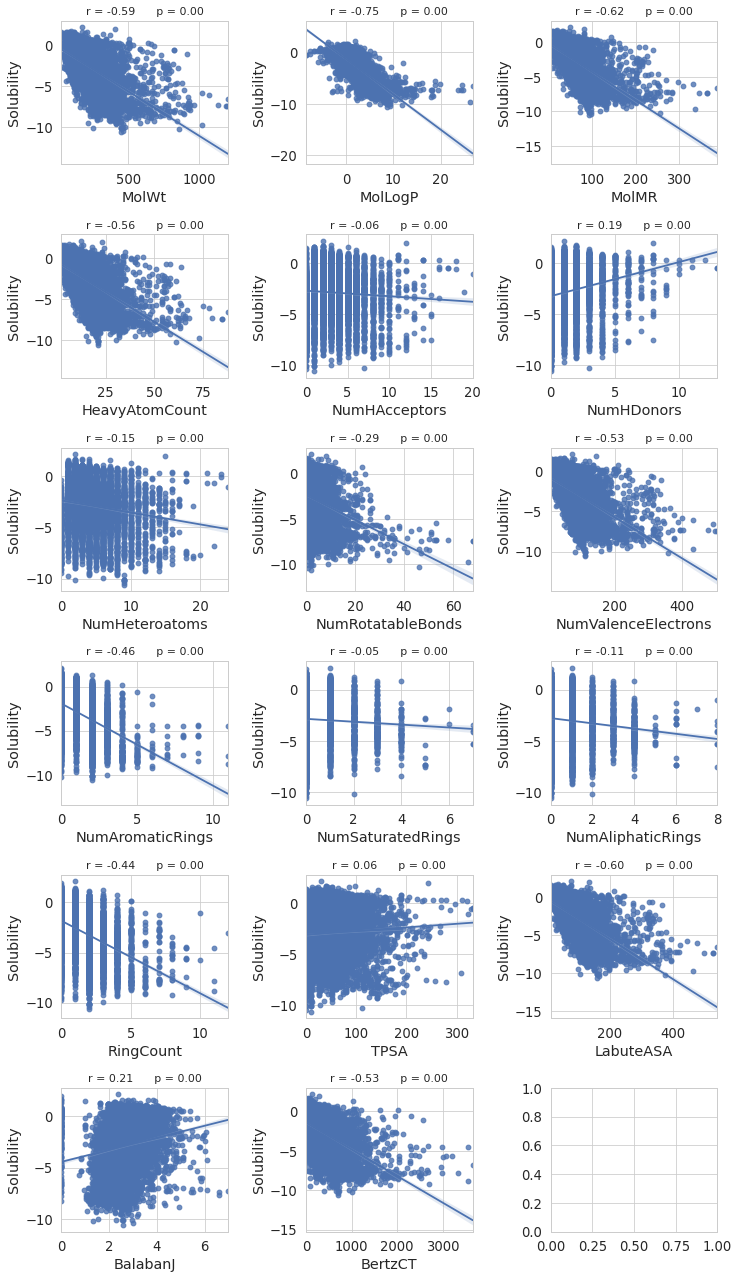

In [12]:
#hide_input
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):
            
            sns.regplot(x=data[descriptors[i]], y=data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(data[descriptors[i]], data[target])

            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()  

Most have a negative correlation with solubility. In fact, the available features reflect more or less the size/complexity of the molecule (e.g. MolWt, RingCount, MolMR) and it's capacity to make inter and intramolecular interactions (e.g., NumValenceElectrons, NumHAcceptors, NumHDonors, MolLogP), which are known to influence water solubility. For instance, bigger molecules tend to be less soluble in water (high MolMW and HeavyAtomCount); the same applies for very liphophilic (high MolLogP) molecules. On the other hand, more polar molecules, capable of making hydrogen bonds with water molecules, are usually more soluble. 

Based on this preliminary analysis we can start thinking which features to include when training a regression model. For instance, molecular weight and liphophilicity are the features most correlated with the target variable. These features have a strong influence in solubility as demonstrated experimentally and by theorical calculations. As the molecular size and liphophilicity grows, its much harder to dissolve a molecule in water because the solute needs to disrupt a great number interactions within solvent molecules and force its way into bulk water, which demands a great amount of energy. The [influence of lipophilicity](https://pubs.acs.org/doi/10.1021/jo01265a071) is so well known that its part of many predictive models, such as the famous [ESOL (estimated solubility)](https://pubs.acs.org/doi/10.1021/ci034243x), which estimates water solubility based only on the molecular structure. 

```Back in the day (2003!) the author didn't even use the robust machine learning algorithms we have today to derive the following equation:```

$$logS_{w} = 0.16 - 0.63logP - 0.0062MolWt + 0.066Rot - -0.74AP$$

where $logS_{w}$ is the log of the water solubility, $logP$ is the lipophilicity, $MolWt$ is the molecular weight, $Rot$ is the number of rotatable bonds (e.g. single bonds) and $AP$ is the proportion of heavy atoms that are part of aromatic rings. 

ESOL is a very simple and useful model; and I've used it multiple times. In the post we'll use ESOL as a baseline against different machine learning algorithms, but for now it's suffice to consider the features used to train the model and how they affect solubility. 

# Understanding the features

## 1) LogP


The logP is the partition coefficient given by:

$$logP = \frac{C_{n-octanol}}{C_{water}}$$

where $C_{n-octanol}$ and $C_{water}$ are the solute concentration in the n-octanol and water, respectively. Thus, higher logP means that a smaller concentration of the molecule is available in the water phase of a system, which makes it more lipophilic or hydrophobic.  

## 2) Molecular weight

Molecular weight (MolWt) is simply the total mass of a mole of a compound (molar mass). The MolWt can be calculated by the summing the contribution of each atom in a molecule. For example, the molar weight of water is:

$$H_{2}O = 2H * (1.01) + 1O * (16) = 18.01 g/mol$$

## 3) Molar refractivity

Molar refractivity (MolMR) is the refractivity of a mole of a substance. It's given by the formula:

$$MolMR = \frac{n^{2}-1}{n^{2}+2}*\frac{MolWt}{d}$$

where $MolWt$ is the molar weight, $d$ is the density and $n$ is the refractivity index. The right hand side of the equation ($\frac{MolWt}{d}$) is the volume. Thus, the molar refractivity encodes the molecular volume and is a way to estimate the steric bulk. 

## 4) Topological polar surface area (TPSA) and LabuteASA


 - **TPSA**: The polar surface area is the sum of the surfaces of polar atoms in a molecule, such as oxygen and nitrogen, and sometimes sulphur and its hydrogen. The total polar surface area is a useful feature to encode both the polarity and the hydrogen bonding capacity of a molecule. 
 

 - **LabuteASA**: the accessible surface area (ASA) is the area of a molecule that is accessible to the solvent (e.g. water). If we consider a water molecule as a ball rolling on the solute structure, the ASA is represented by all parts the water ball can interact with. 

![TPSA](https://docs.eyesopen.com/toolkits/cookbook/python/_images/psa2img.png)

**Figure 1**. Representation of the polar surface area, showing the contributions of each polar atom in the molecule.

![TPSA](images/asa.png)

**Figure 2**. Representation of the polar surface area, showing the contributions of each polar atom in the molecule.

Labute's Approximate Surface Area

## 5) Atomic counts

Atomics counts represent the number of a give feature in a molecule. Its possible to count specific substructures (e.g. number of aromatic rings), atoms and atoms types, hydrogen bond donors and acceptors etc. 

## 6) Topological descriptors

Topological descriptors in this dataset include [BalabanJ](http://publications.iupac.org/pac/55/2/0199/index.html) and BertzCT and represent more abstract definition of a molecule. For the BalabanJ, the feature value is calculated from the distance matrix, a n x n matrix where n is the number of atoms and the entries represent the distances between each atom in the molecular graph. The BalabanJ descriptor can thus capture topological information such as branching, distance between substructures and the molecular size. 
The BertzCT descriptor encodes the molecular complexity by taking into account bond connectivity and atom types.

**Now let's get to work!**

## **Summary statistics**

In [13]:
data[descriptors+['Solubility']].describe()

MolWt      MolLogP        MolMR  HeavyAtomCount  NumHAcceptors  \
count  8525.000000  8525.000000  8525.000000      8525.00000    8525.000000   
mean    245.365612     2.341470    64.593645        16.53349       3.152493   
std     122.572064     2.441439    34.088365         8.66311       2.283460   
min      26.038000    -8.424200     3.450000         2.00000       0.000000   
25%     162.019000     0.944400    42.054500        11.00000       2.000000   
50%     223.253000     2.100300    58.590000        15.00000       3.000000   
75%     303.358000     3.450300    79.729000        20.00000       4.000000   
max    1205.976000    26.759600   389.459200        88.00000      20.000000   

        NumHDonors  NumHeteroatoms  NumRotatableBonds  NumValenceElectrons  \
count  8525.000000     8525.000000        8525.000000          8525.000000   
mean      1.087273        4.545455           3.867331            89.963754   
std       1.311210        2.934200           4.817322            46.581591   
min       0.000000        0.000000           0.000000            10.000000   
25%       0.000000        2.000000           1.000000            60.000000   
50%       1.000000        4.000000           3.000000            82.000000   
75%       2.000000        6.000000           5.000000           108.000000   
max      13.000000       24.000000          68.000000           504.000000   

       NumAromaticRings  NumSaturatedRings  NumAliphaticRings    RingCount  \
count       8525.000000        8525.000000        8525.000000  8525.000000   
mean           1.052669           0.291026           0.435191     1.487859   
std            1.106026           0.735964           0.927160     1.368085   
min            0.000000           0.000000           0.000000     0.000000   
25%            0.000000           0.000000           0.000000     0.000000   
50%            1.000000           0.000000           0.000000     1.000000   
75%            2.000000           0.000000           1.000000     2.000000   
max           11.000000           7.000000           8.000000    12.000000   

              TPSA    LabuteASA     BalabanJ      BertzCT   Solubility  
count  8525.000000  8525.000000  8525.000000  8525.000000  8525.000000  
mean     55.384868   100.659842     2.628596   431.736329    -2.897943  
std      41.005501    51.125957     0.793407   352.153522     2.238765  
min       0.000000    11.307062    -0.000004     0.000000   -10.600000  
25%      26.300000    66.507237     2.177270   179.490302    -4.240000  
50%      49.330000    91.207257     2.631436   359.709158    -2.653800  
75%      75.270000   124.004828     3.074465   599.334888    -1.346100  
max     331.940000   542.556023     6.978597  3655.220196     2.137682

# In depth analysis of feature correlation

Let's take a look at the [```pairplot```](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to see how the features interact with each other and with our target. 

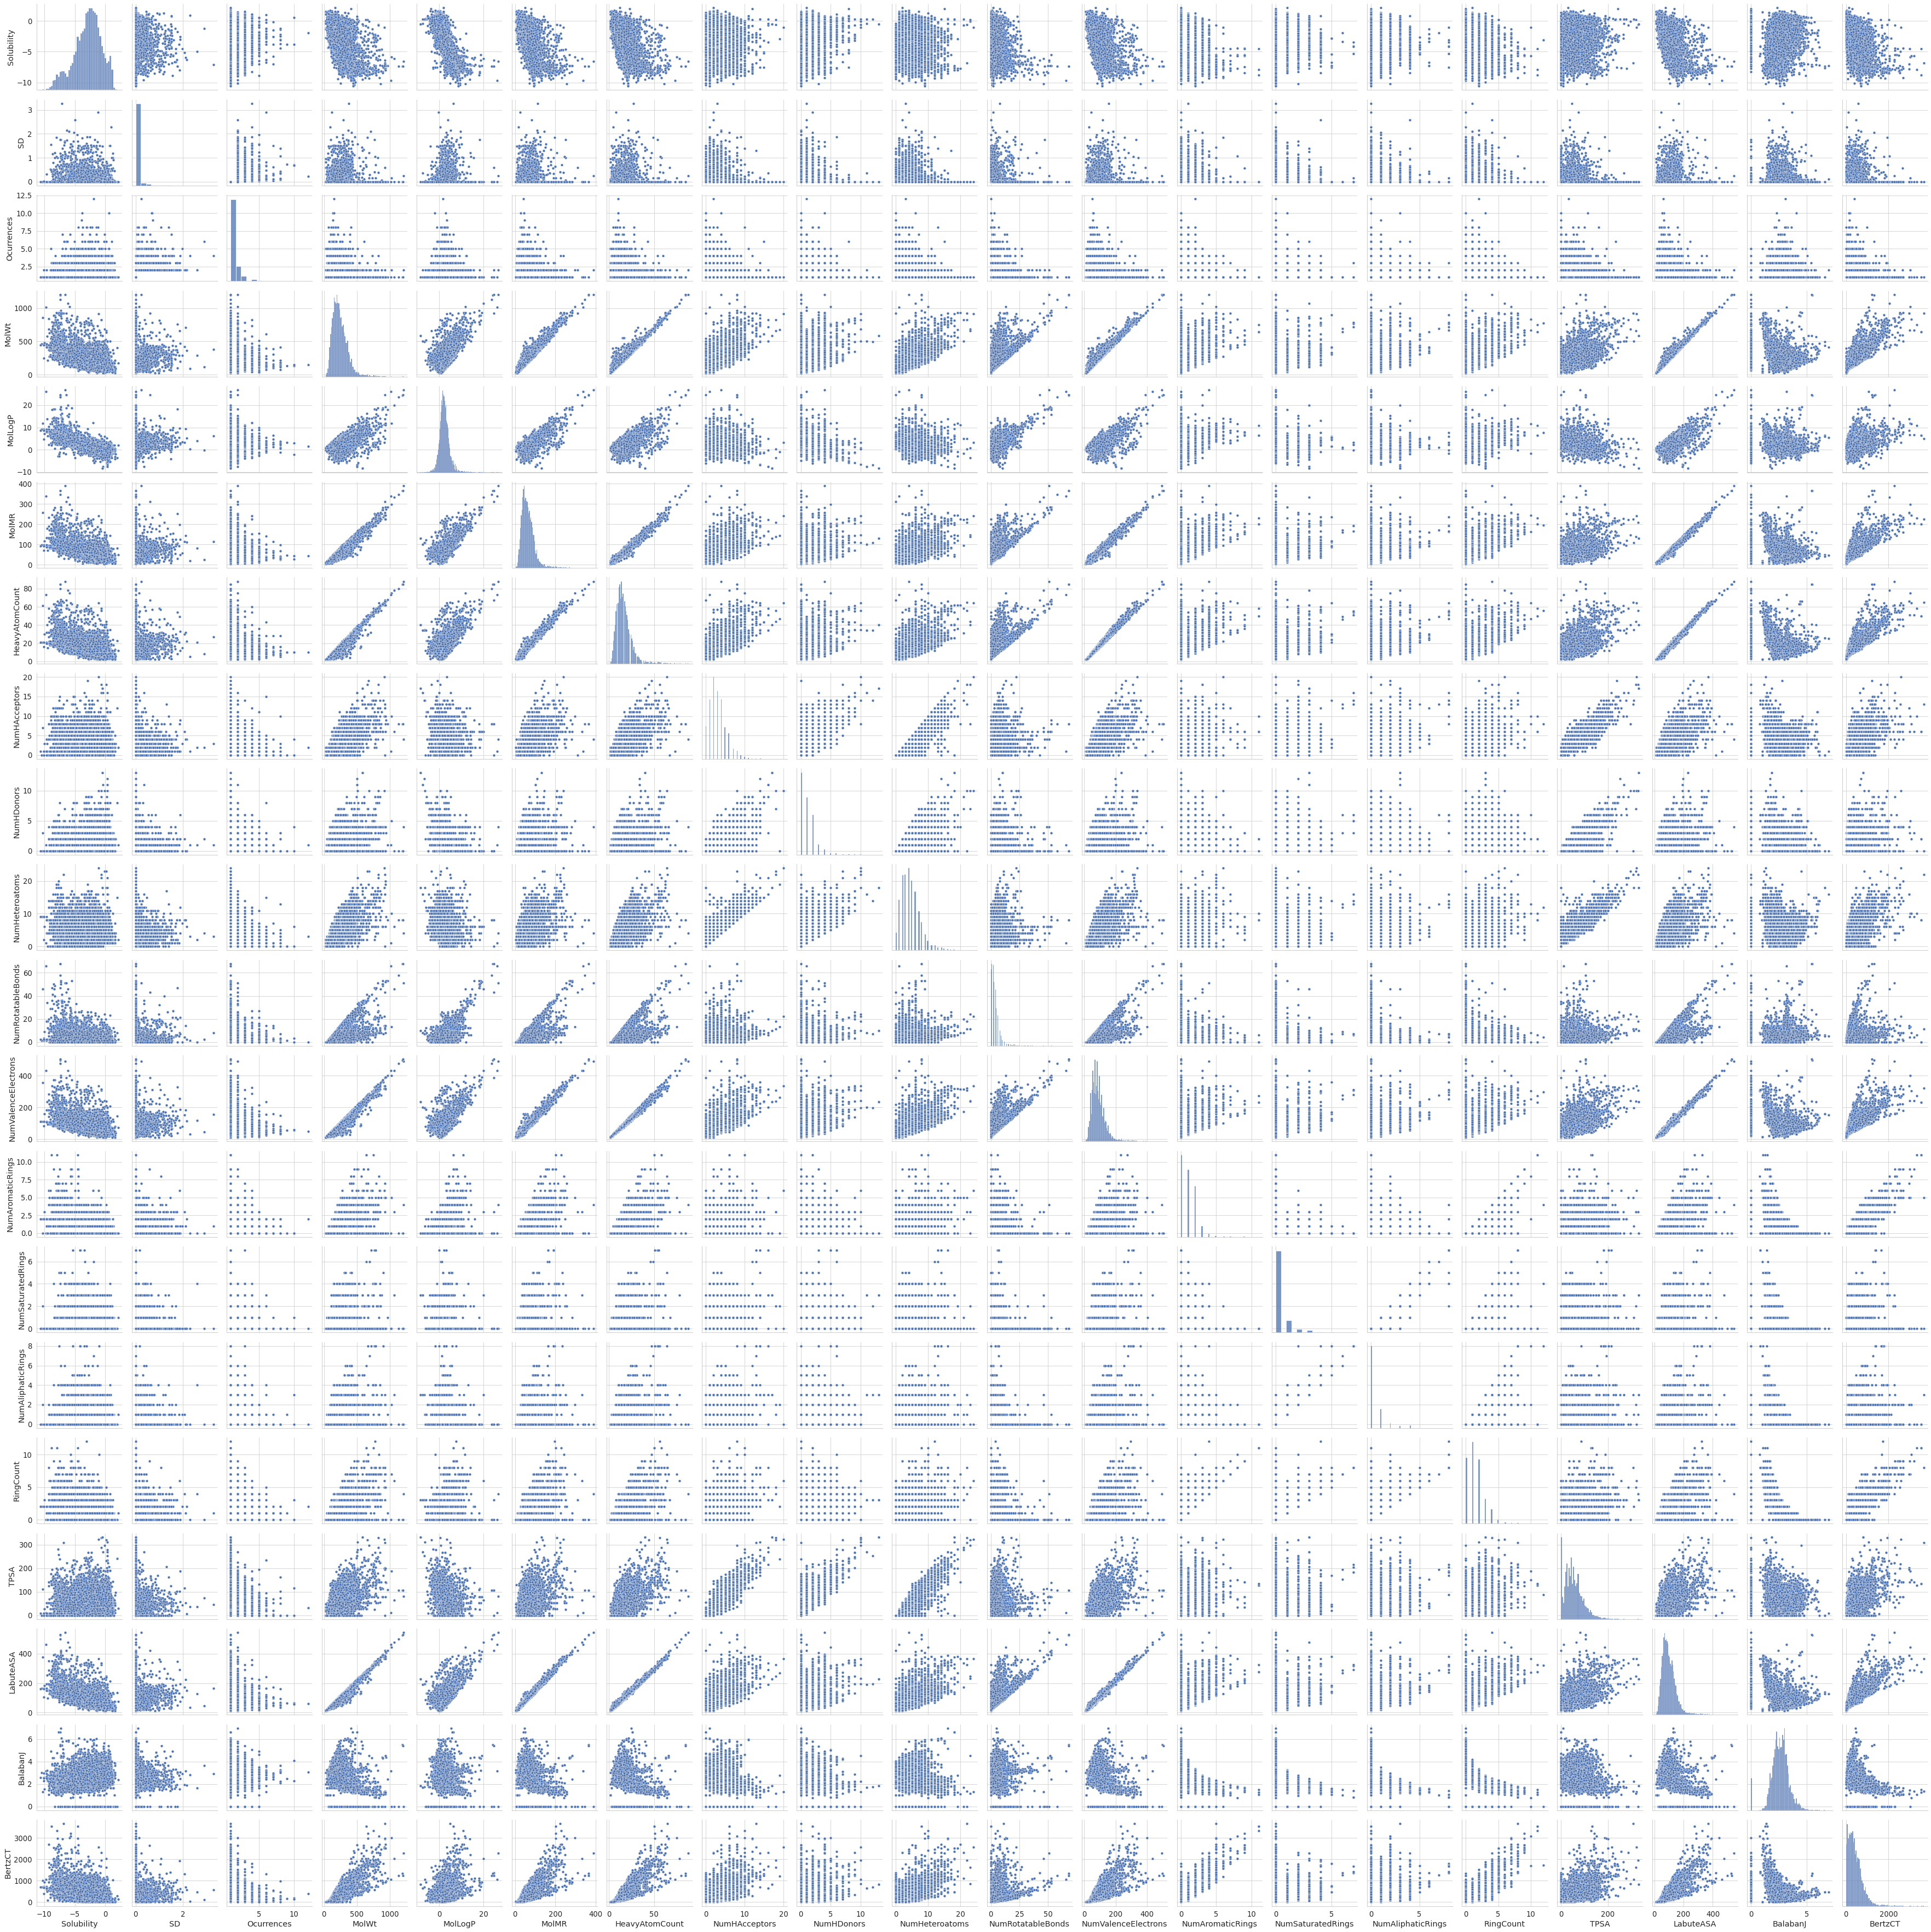

In [14]:
#collapse_output
sns.pairplot(data)

An even better way to visualize the correlation between features is to plot a heatmap using ```sns.heatmap```.

First, let's calculate the Pearson's R coefficient for each pair of features. 

The largest diagonal corresponds to self correlation for each feature (e.g. MolWt x MolWt), and is always 1. The most interesting part are the other values, showing the correlation between each pair. 

As we can see from the heatmap, some features have a high negative linear correlation, such as MolWt (-0.61) and LabuteASA (-0.62), MolLogP (-0.78) and MolMR (-0.64), HeavyAtomCount (-0.57). The negative correlations are what we would expect from correctly calculated descriptors. 

We can also investigate the correlations between features. For the BalabanJ descriptor, the highest correlation was with RingCount (-0.64). For BertzCT, the highest correlations were with features that encode the molecular complexity/size, such as molecular weight, molar refractivity and number of heavy atoms, which is consistent with its definition. Thus, the correlations in the heatmap correspond to what we expect from the molecular properties represented by each feature. 

In [15]:
corr = data[var].corr('pearson')

<AxesSubplot:>

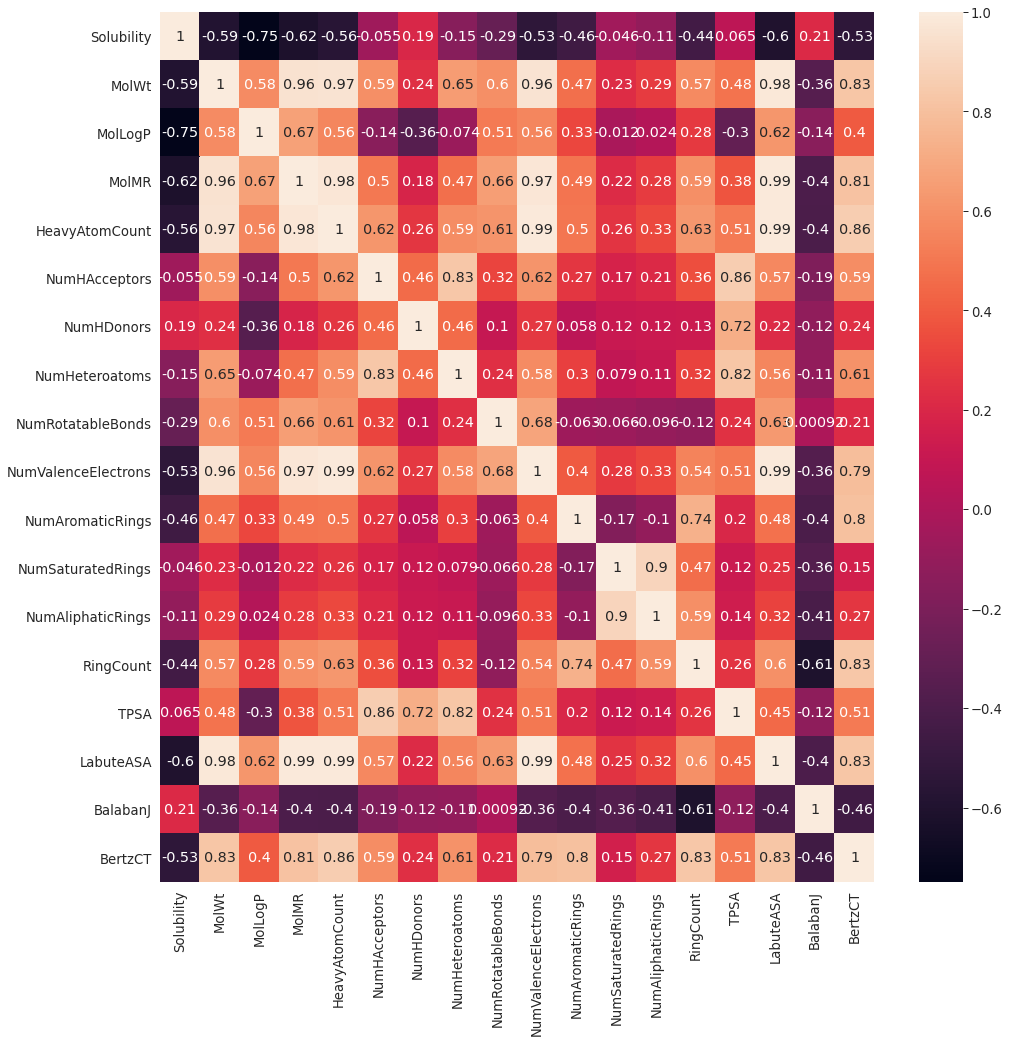

In [16]:
sns.heatmap(corr, annot=True)

We can also see that the number of hydrogen bond donors have a weak positive correlation with solubility, while the number of H-bond acceptors have a very weak negative correlation. This is interesting because it shows us that increasing the H-bond potential might not be the best strategy to increase solubility. 

In general, [increasing H-bond donors and acceptors also increases solubility](https://www.sciencedirect.com/science/article/abs/pii/S0022354915508666) because it alters the capacity to make H-bonds with water molecules. . However, if the molecule can both donate and accept H-bonds, a decrease in solubility might happen due to intermolecular interactions between molecules of the same kind, leading to reduced ability to be solvated by water molecules. 
The intuition is that a molecule needs to make better interactions with water than with others of its kind, otherwise it will be poorly solvated.

To summarize this initial analysis, the heatmap give us an idea of what types of features to include in a regression model model. If we were to cherry pick, features like **MolLogP**, **MolMR** and **LabuteASA** would probably be selected. But no need to rush! We'll systematically check each features for better correlations with the target variable and with each other. Remember that our goal is to develop a model with high predictive power, and to do that we need to select the right set of features. 

# Training a baseline model

Before we dive into feature selection, let's try a baseline model and see how it performs when training using all features. For this task, we will use the Random Forest algorithm. First, split the data into training and testing sets.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
trainset, testset = train_test_split(data, test_size = 0.30, random_state=42)

Since our features are in different scales, let's normalize them to have zero mean and unit std. This is an important step so that one feature with large std doesn't dominate the others during training, which could lead to overfitting. But will do the preprocessing in a more compact way by using sklearn pipeline, which will contain the preprocessing steps and a fit call to the training algorithm.

In [19]:
xtrain, xtest = trainset[descriptors].values, testset[descriptors].values
ytrain, ytest = trainset['Solubility'].values, testset['Solubility'].values

In [20]:
from sklearn.pipeline import Pipeline

In [21]:
pipe = Pipeline(steps=[('scaler',RobustScaler()), ('estimator', RandomForestRegressor(n_estimators=2000, n_jobs=-1))])

We will validate our model using 5-fold crossvalidation. 

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
metric = make_scorer(mean_squared_error, squared=False) # RMSE
cross_score = cross_val_score(estimator=pipe, X=xtrain,scoring=metric, y=ytrain, cv=5, n_jobs=-1)

In [24]:
print(f'Mean 5-fold RMSE = {cross_score.mean():.4f}')

Mean 5-fold RMSE = 0.9980


Now the test set:

In [25]:
pipe.fit(xtrain,ytrain)

Pipeline(steps=[('scaler', RobustScaler()),
                ('estimator',
                 RandomForestRegressor(n_estimators=2000, n_jobs=-1))])

In [26]:
def get_preds(estimator, x):
    preds = estimator.predict(x)
    return preds

In [27]:
preds = pipe.predict(xtest)

In [28]:
print(f'RMSE test set = {mean_squared_error(preds, ytest, squared=False)}')

RMSE test set = 0.9634041074594073


Not bad! This is our baseline. Let's see if we can beat it or simplify our data a little bit without compromising performance. 

### The perils of non-informative features

What happens if we only have non-informative features in the dataset? What performance could we expect? Intuitively, one would say RMSE >> 0. Let's test that by randomizing our target variable, which will make every feature **non-informative**. 

In [29]:
yrandom = np.random.choice(ytrain,ytrain.shape[0])

In [30]:
yrandom.shape,ytrain.shape

((5967,), (5967,))

In [31]:
yrandom, ytrain

(array([-1.7       ,  1.00830886, -4.45042772, ..., -2.56313048,
        -1.063     , -2.7813    ]),
 array([-5.05611784, -1.02322129, -8.7546501 , ..., -0.7956    ,
        -1.11610783, -4.561     ]))

In [32]:
pipe.fit(xtrain,yrandom)
preds_random = pipe.predict(xtest)

In [33]:
print(f'RMSE (randomized target) test set = {mean_squared_error(preds_random, ytest, squared=False)}')

RMSE (randomized target) test set = 2.3878056084158237


As you can see, the RMSE on the test set does increase. In a data set with dozens or even hundreds of features, which is relatively common in QSAR applications we would expect much higher errors. That's why it's so important to analyze your features very carefully in order to remove anything that could hamper performance, including missing or constant values and highly correlated features. 

# Feature selection

In our solubility dataset we have 17 features but we could have more. There are hundreds of molecular descriptors available in literature. So, how does one select the best set of features do include in a model? Let's investigate some feature selection methods!

## 1) Filter methods


Filter methods are the easiest the implement because they are model-agnostic, which means we don't need any fancy learning algorithm; we just need our data. This class of methods consists of statistical approaches that use the distribution of the dataset to remove features that don't have much information or correlation with the target variable. Since we do need a model, filter methods are very fast and can give an initial guess of what types of features to keep. 

Despite being fast, filter methods also come with some dangerous drawbacks. Since most methods are **univariate**, important correlations between features may be missed; or worse redudant features could be selected. In addition, most metrics (e.g. Pearson's correlation coefficient) used to select the features are subjective and the user needs to specify a threshold value. 

    While filter methods tend to be simple and fast, there is a subjective nature to the procedure. Most scoring methods have no obvious cut point to declare which predictors are important enough to go into the model. Even in the case of statistical hypothesis tests, the user must still select the confidence level to apply to the results. In practice, finding an appropriate value for the confidence value α may require several evaluations until acceptable performance is achieved
    
```Applied Predictive Modeling, p.499.```

### 1.1) Basic approaches

Basic approaches are purely statistical and consits of removing constant or quasi-constant features from the dataset. 

#### 1.1.1) Remove constant features using variance threshold

The first method we will use consists of removing constant or quasi-constant features. In this situation, all samples have the same value or almost the same. The intuition to remove this kind of feature is that it doesn't add any useful information to training. 

In [34]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression

In [35]:
selector = VarianceThreshold()

In [36]:
scaler = RobustScaler()
xnorm = scaler.fit(xtrain).transform(xtrain)


In [37]:
reducer = VarianceThreshold()
reducer.fit(xnorm)

VarianceThreshold()

We can get the final number of features by using the ```get_support``` method from a fitted reducer. 

In [38]:
sum(reducer.get_support())

17

Well, it seems we don't have any feature with 0 variance. That's a good thing! But what about features with less than 1% variance?

In [39]:
reducer = VarianceThreshold(threshold=0.01)
reducer.fit(xnorm)

VarianceThreshold(threshold=0.01)

In [40]:
sum(reducer.get_support())

17

Again no feature was removed. That's a good start. Let's try more robust methods!

### 1.2) Univariate selection methods

#### Mutual information

[Mutual information](https://thuijskens.github.io/2017/10/07/feature-selection/) is a *linear* approach to measure between two (possibly multi-dimensional) random variables $X$ and $Y$, that quantifies the amount of information obtained about one random variable through the other random variable. The mutual information is given by:

$$
\begin{align}
I(X; Y) = \int_X \int_Y p(x, y) \log \frac{p(x, y)}{p(x) p(y)} dx dy
\end{align}
$$

If the joint distribution $p(x,y)$ of variables $X$ and $Y$ equals the individual probabilities $p(x)$ and $p(y)$, the variables are considered independent and the integral is 0. Therefore, our goal is to find variables that are somehow correlated with the dependent variable logS. 

In [41]:
from sklearn.feature_selection import mutual_info_regression

In [42]:
importances = mutual_info_regression(xtrain, ytrain)

In [43]:
df_importances = pd.DataFrame(importances,index=descriptors)

In [44]:
df_importances.sort_values(0,ascending=False).head(20)

0
MolLogP              0.618195
MolWt                0.451355
MolMR                0.444390
LabuteASA            0.423057
NumValenceElectrons  0.366864
HeavyAtomCount       0.355654
BertzCT              0.278940
RingCount            0.186475
NumAromaticRings     0.178595
BalabanJ             0.140178
TPSA                 0.103172
NumHAcceptors        0.088184
NumRotatableBonds    0.080012
NumHeteroatoms       0.070472
NumHDonors           0.059317
NumAliphaticRings    0.024100
NumSaturatedRings    0.019100

It seems that the top-20 most important features makes sense; as mentioned before logP and the molecular weight are important parameters to estimate water solubility. In fact, the top-20 features are what we expect based on the Pearson's R heatmap! That's very good, we can see the feature selection methods are showing some consistence and now we are bit more confident that we should include logP and some feature that encode structural information about the molecules. 

For the bottom 20 features we can see that the are mostly related to atomic or fragment counts, which does tells us something about the structure but are not determinant for solubility per se.

We can also use the mutual information as metric in the sklearn [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) class.

In [45]:
from sklearn.feature_selection import SelectKBest

In [46]:
kbest = SelectKBest(score_func=mutual_info_regression)
xkbest = kbest.fit_transform(xtrain, ytrain)

The ```get_support``` method returns a bool array that we can use to index the list of descriptors. 

In [47]:
np.array(descriptors)[kbest.get_support()]

array(['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumValenceElectrons', 'NumAromaticRings', 'RingCount',
       'LabuteASA', 'BalabanJ', 'BertzCT'], dtype='<U19')

In general, the most used approach is to use SelectKBest and select a scoring method, which will depend on the kind of variable we have. For continuous variables in regression problems, the [f_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) and [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) scoring functions are available on scikit-learn. For categorical variables in a classification problem, one can use Fischer [chi-squared](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2), [mutual information for classification](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) (mutual_info_classif) and the [ANOVA F-value (f_classif)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif)

# 2) Wrapper methods

Wrapper methods consists of using models to decide if a feature should be added or removed. The main idea is to find a subset of features that maximize the performance. In this class of methods we have feature importances calculated from random forest models, forward and backward selection and recursive feature elimination (RFE). Another way to understand wrapper methods is to think of them as search algorithms, with the features representing the search space and model performance was the target metric. 

## 2.1) Forward selection

In forward selection we add features one at a time and evaluate the performance. If the performance on iteration $i+1$ is better than the previous $i^{th}$ iteration, we keep the new feature. The algorithm stops when the addition of new features does not lead to an increase in performance. 

Let's implement a naive approach to forward selection.

In [48]:
from sklearn.base import clone
from tqdm.notebook import tqdm

class ForwardSelection():
    def __init__(self, estimator, X, y, scoring, test_size):
        self.estimator = clone(estimator)

        self.X = X
        self.dim = X.shape[1]
        self.y = y
        self.scoring = scoring
        self.test_size = test_size
        
    def fit_predict(self): 
        
        index = tuple(range(self.dim))
        
        self.subset = []
        
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(self.X,self.y,test_size=self.test_size)
        
        self.scores = [self._calc_score(self._no_features(Xtrain), Ytrain, Xtest, Ytest)]
        
        for i in index:

            Xtransform, Xtest_transform = self.transform(Xtrain,i), self.transform(Xtest,i)


            score = self._calc_score(Xtransform, Ytrain, Xtest_transform, Ytest)
         #   print(i, score, np.min(self.scores))
            
            if score < np.min(self.scores):
                print(f'Found import feature {descriptors[i]} with new min RMSE of {score:.3f}')
                self.subset.append(i)
                self.scores.append(score)
                   
    
    def transform(self, X, i): 
        return X[:, self.subset + [i]].reshape(-1, len(self.subset + [i])) 
    
    def _calc_score(self, Xtrain, ytrain, Xtest, y_test):
        
        self.estimator.fit(Xtrain, ytrain)
        preds = self.estimator.predict(Xtest)

        score = self.scoring(preds, y_test)

        return score
    
    def get_support(self):
            
        return self.subset
    
    def _no_features(self, x):
        return np.zeros(x.shape)

In [49]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [50]:
pipe_ffs = Pipeline(steps=[('scaler',RobustScaler()), ('estimator', LinearRegression())])

In [51]:
ffs = ForwardSelection(pipe_ffs, xtrain, ytrain, scoring = partial(mean_squared_error, squared=False), test_size=0.25)

In [52]:
ffs.fit_predict()

Found import feature MolWt with new min RMSE of 1.756
Found import feature MolLogP with new min RMSE of 1.426
Found import feature MolMR with new min RMSE of 1.411
Found import feature HeavyAtomCount with new min RMSE of 1.396
Found import feature NumHeteroatoms with new min RMSE of 1.393
Found import feature NumRotatableBonds with new min RMSE of 1.340
Found import feature TPSA with new min RMSE of 1.339
Found import feature LabuteASA with new min RMSE of 1.338
Found import feature BalabanJ with new min RMSE of 1.338


In [53]:
selected_features = np.array(descriptors)[ffs.get_support()]
print(f'Number of selected features = {len(selected_features)}')

Number of selected features = 9


Our naive forward selector found 13 important features. If we go back to our heatmap, we can see that the selected features do have some correlation with solubility! Furthermore, it's basically the same features selected by the mutual information metric in the previous section. 

Now let's try the faster and reliable scikit-learn implementation of forward selection, the [```SequentialFeatureSelector```](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) class. 

We need to define a number of features to select so let's use 10 and compare the results with the approches so far. 

In [54]:
from sklearn.feature_selection import SequentialFeatureSelector

In [55]:
ssf = SequentialFeatureSelector(estimator=pipe_ffs,n_features_to_select=12,cv=5, direction='forward',scoring='neg_mean_squared_error')

>It seems SequentialFeatureSelector tries to **maximize** the scoring function. If we use the ```make_scorer(mean_squared_error)``` the selector will output features that increase the RMSE. 

In [56]:
ssf.fit(xtrain, ytrain)

SequentialFeatureSelector(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                                    ('estimator',
                                                     LinearRegression())]),
                          n_features_to_select=12,
                          scoring='neg_mean_squared_error')

In [57]:
selected_features_ssf = np.array(descriptors)[ssf.get_support()]

In [58]:
selected_features_ssf

array(['MolLogP', 'MolMR', 'HeavyAtomCount', 'NumHAcceptors',
       'NumHeteroatoms', 'NumRotatableBonds', 'NumValenceElectrons',
       'NumSaturatedRings', 'RingCount', 'LabuteASA', 'BalabanJ',
       'BertzCT'], dtype='<U19')

There we go! Our naive approache gives similar results to sklearn implementation. As always, MolLogP was selected as an informative feature. 

## 2.2) Backward selection

We can also do backward selection. In this method, we start with the whole set of features and remove at each step remove the ones that do not improve the model.

In [59]:
ssf_backward = SequentialFeatureSelector(estimator=pipe_ffs,n_features_to_select=0.5,cv=5, direction='backward',scoring='neg_mean_squared_error')

In [60]:
ssf_backward.fit(xtrain, ytrain)

SequentialFeatureSelector(direction='backward',
                          estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                                    ('estimator',
                                                     LinearRegression())]),
                          n_features_to_select=0.5,
                          scoring='neg_mean_squared_error')

In [61]:
selected_features_ssf = np.array(descriptors)[ssf_backward.get_support()]
print(selected_features_ssf)

['MolLogP' 'HeavyAtomCount' 'NumHeteroatoms' 'NumRotatableBonds'
 'NumValenceElectrons' 'LabuteASA' 'BalabanJ' 'BertzCT']


## 2.3) Recursive feature elimination

Recursive feature elimination is another backward selection method but with the benefit of not fitting models using the same data multiple times. The first step consists of training the model on the full set of features. Then, the performance is calculated and the features are ranked in order of importance. The method iteratively removes features that are not important and rebuilds the model to estimate its performance and ranking of the remaining features. The process stops when a predefined number of features is reached. In scikit-learn, we can use ```RFE``` as is or coupled with cross-validation (```RFECV```), in which case the mean cross-validated scored is returned. 

In [62]:
from sklearn.feature_selection import RFE, RFECV

In [63]:
xnorm = scaler.fit_transform(xtrain)
rfe = RFECV(estimator=LinearRegression(), cv=5, step=1)

In [64]:
rfe.fit(xnorm, ytrain)

RFECV(cv=5, estimator=LinearRegression())

In [65]:
np.array(descriptors)[rfe.support_], rfe.ranking_

(array(['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumHDonors',
        'NumHeteroatoms', 'NumRotatableBonds', 'NumValenceElectrons',
        'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ', 'BertzCT'],
       dtype='<U19'),
 array([1, 1, 1, 1, 5, 1, 1, 1, 1, 2, 4, 3, 1, 1, 1, 1, 1]))

Again, consistent results with the previous selection methods. 

# 3) Selecting directly from a model

In scikit-learn, models that returns ```coef_``` or ```feature_importances_``` assigns importances to the features and we can use these models to select an optimal subset of features for training. 

## 3.1) [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#forest)

Random forest is a learning algorithm that uses the average response of an ensemble of decision trees to make a prediction. Each tree considers a random subset of the features in order to make its predictions. At each node, the algorithm tries to minimize the **impurity** of a split or maximize its **gain**, which is similar to reducing the number of wrong predictions. We can use the average decrease in impurity of the trees at each split to rank the features the model considered most important to make its decision. In scikit-learn, the importances of fitted random forest can be accessed via the ```feature_importance_``` attribute.

In [66]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
rf = RandomForestRegressor(n_estimators=2000, n_jobs=-1)

In [68]:
rf.fit(xtrain, ytrain)

RandomForestRegressor(n_estimators=2000, n_jobs=-1)

In [91]:
importances = rf.feature_importances_.reshape(1,-1)

In [97]:
def rf_feat_importance(model, feats_names):
    return pd.DataFrame({'cols':feats_names, 'imp':model.feature_importances_}).sort_values('imp',ascending=False)

In [98]:
fi = rf_feat_importance(rf, descriptors)

<AxesSubplot:xlabel='imp', ylabel='cols'>

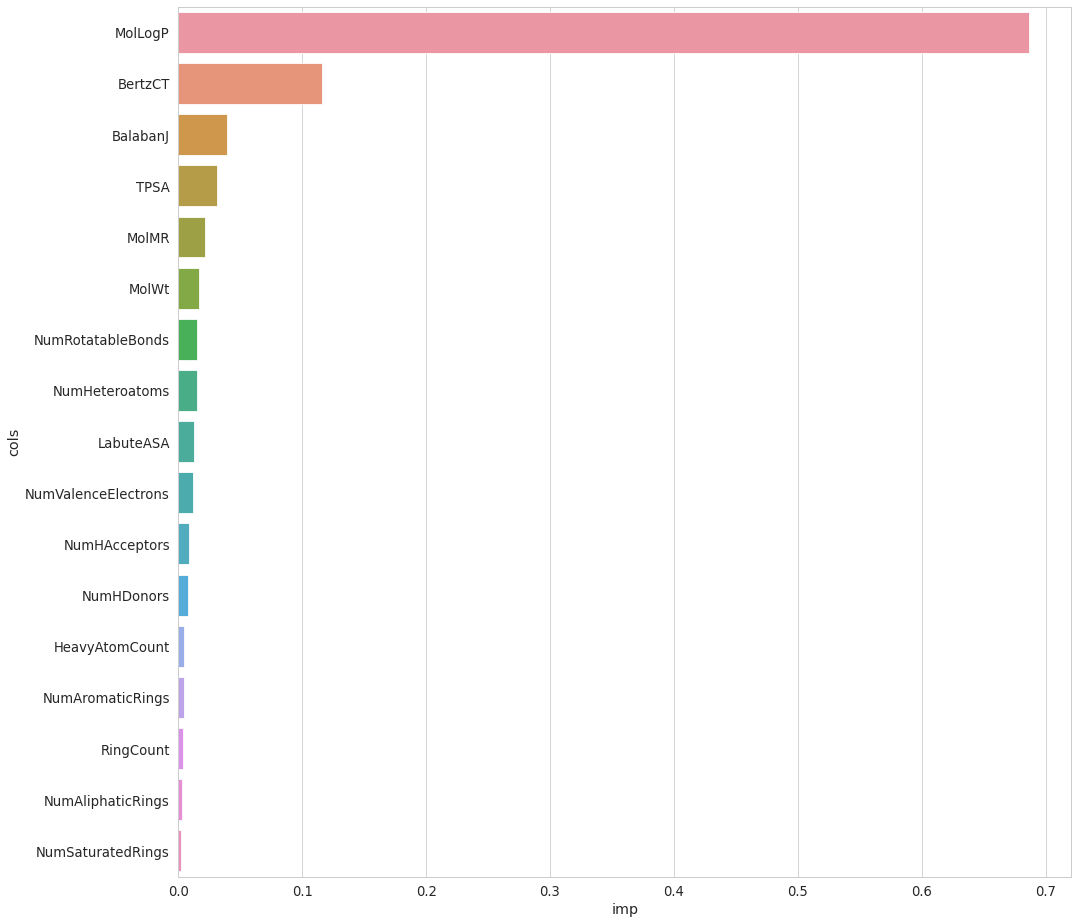

In [101]:
sns.barplot(y='cols', x='imp',data=fi)

The relative importance is normalized to sum up to 1.0. Features with higher importances are assigned higher values. Thus, MolLogP was the most relevant feature for random forest, followed by BertzCT and BalabanJ (both are topological descriptors). Features based on counts of atoms or fragments were assiged very small importances, which means that we could probably remove than from the data and without impacting performance so much. 

## 3.2) [LASSO](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

LASSO is a linear model trained with L1 regularization in order to reduce model complexity. By "reduce complexity" I mean make the model simpler to gain a boost in generalization. LASSO achieves regularization by using the L1 norm:




$$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$$

The L1 norm consists of adding the sum of the absolute values of the weights or coefficients to the cost function (e.g. sum of squared errors in a regression problem). In practice regularization forces the model to learn smaller weights, which is a way of making it simpler. Under L1 norm, most weights will be zero and as a result the weight vector will be sparse. Thus, the sparcitiy of the feature vector makes LASSO a great tool for feature selection since most unimportant features will be zeroed out. 

Let's try scikit-learn implementation of LASSO.

In [103]:
from sklearn.linear_model import Lasso

The alpha hyperparameter is a penalization term. If alpha = 0, LASSO becomes ordinary least square (e.g. LinearRegression). The default value is 1.0 but we will reduce it in order to make the model more flexible and not zero out all features. 

In [126]:
pipe_lasso = Pipeline(steps=[('scaler',RobustScaler()), ('estimator', Lasso(alpha=0.1))])

In [127]:
pipe_lasso.fit(xtrain, ytrain)

Pipeline(steps=[('scaler', RobustScaler()), ('estimator', Lasso(alpha=0.1))])

We can access the coefficients of the lasso estimator via the ```coef_``` attribute of the pipeline. 

In [128]:
feature_coef = pipe_lasso.named_steps.estimator.coef_

In [129]:
feature_coef

array([-0.0024517 , -1.46516244, -0.        , -0.        , -0.        ,
        0.        , -0.05151828,  0.09117961, -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.56361338])

That's how the magic happens! The LASSO esimator zeroed out most features. It seems only 5 features survived the ordeal. 

In [130]:
np.array(descriptors)[np.where(feature_coef!=0.)[0]]

array(['MolWt', 'MolLogP', 'NumHeteroatoms', 'NumRotatableBonds',
       'BertzCT'], dtype='<U19')

I'm not surprised at all! We can see features that were also selected by some of the previous methods. 

# References

**Molecular descriptors**

https://northstar-www.dartmouth.edu/doc/MOE/Documentation/quasar/descr.htm#KH

http://www.codessa-pro.com/descriptors/index.htm


**Normality tests**

Machine learning mastery post: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

Shapiro-Wilk test: https://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm

Anderson-Darling test : https://www.itl.nist.gov/div898/handbook/prc/section2/prc21.htm


GraphPad entry: https://www.graphpad.com/guides/prism/latest/statistics/stat_choosing_a_normality_test.htm

# **Fin**